In [1]:
#7.3.1. NiN 块
!pip install d2l
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU())

     |████████████████████████████████| 81kB 5.6MB/s 


In [2]:
#7.3.2. NiN 模型
#最初的 NiN 网络是在 AlexNet 后不久提出的，显然从中得到了一些启示。 
#NiN使用窗口形状为  11×11 、 5×5  和  3×3 的卷积层，
#输出通道数量与 AlexNet 中的相同。 每个 NiN 块后有一个最大池化层，
#池化窗口形状为  3×3 ，步幅为 2。

#NiN 和 AlexNet 之间的一个显著区别是 NiN 完全取消了全连接层。 
#相反，NiN 使用一个 NiN块，其输出通道数等于标签类别的数量。
#最后放一个 全局平均池化层（global average pooling layer），生成一个多元逻辑向量（logits）。
#NiN 设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小, 10)
    nn.Flatten())

In [3]:
#我们创建一个数据样本来查看每个块的输出形状。
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.363, train acc 0.864, test acc 0.876
1040.7 examples/sec on cuda:0


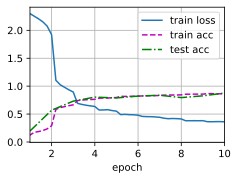

In [4]:
#7.3.3. 训练
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())